In [6]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.autograd import Variable



In [57]:
ababa = (0.5, 1, 0.5)
transform = transforms.Compose([
    transforms.Resize(50),
    transforms.CenterCrop(50),
    transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Normalize(ababa, ababa)
])

In [58]:
dataset = datasets.ImageFolder('training_set', transform=transform)
N_CLASSES = len(dataset.classes)
print(dataset.classes)

['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


In [59]:
train_set, val_set = random_split(dataset, [0.7, 0.3])
trainloader, valloader = DataLoader(train_set, batch_size=32, shuffle=True), DataLoader(val_set, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


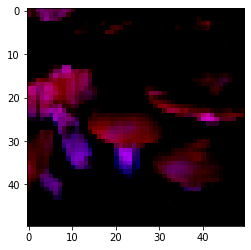

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


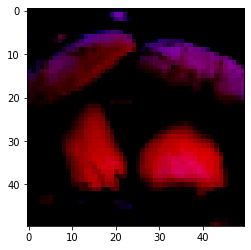

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


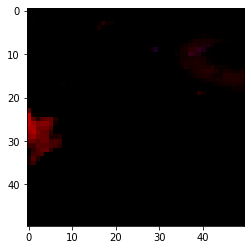

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


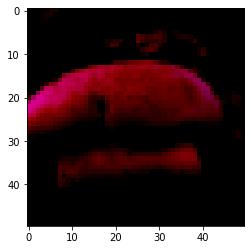

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


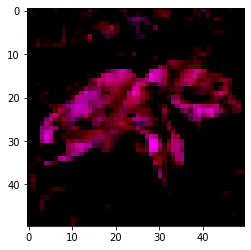

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


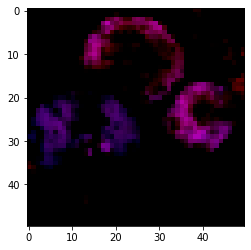

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


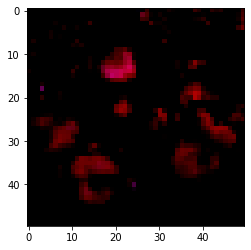

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


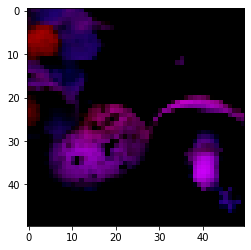

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


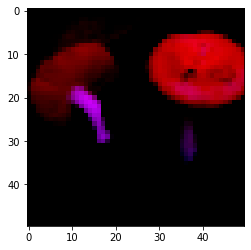

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


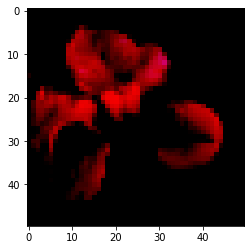

In [60]:
def imageshow(img):
    #img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, _ = next(iter(valloader))
for i, image in enumerate(images[:10]):
    imageshow(image)

In [31]:
class mush_rec_nn(nn.Module):
    def __init__(self):
        super(mush_rec_nn, self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        
        self.cnn2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.cnn4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        
        self.cnn5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        
        self.fc1 = nn.Linear(24 * 16 * 16, N_CLASSES)
    
    def forward(self, input):
        output = F.relu(self.bn1(self.cnn1(input)))
        output = F.relu(self.bn2(self.cnn2(output)))     
        output = self.pool(output)                        
        output = F.relu(self.bn4(self.cnn4(output)))     
        output = F.relu(self.bn5(self.cnn5(output)))     
        output = output.view(-1, 24 * 16 * 16)
        output = self.fc1(output)
        
        return output

model = mush_rec_nn()

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [33]:
def saveModel():
    path = "./mush_rec_model.pth"
    torch.save(model.state_dict(), path)

def testAccuracy():
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            
            outputs = model(images)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs):
    
    best_accuracy = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    
    model.to(device)

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(trainloader, 0):
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))

            optimizer.zero_grad()
            
            outputs = model(images)
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 999:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 1000))
                running_loss = 0.0

        accuracy = testAccuracy()
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))
        
        if accuracy > best_accuracy:
            saveModel()
            best_accuracy = accuracy

In [ ]:
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(valloader))

    # show all images as one image grid
    imageshow(make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

In [36]:
# Let's build our model
train(5)
print('Finished Training')
# Test which classes performed well
testAccuracy()

# Let's load the model we just created and test the accuracy per label
model = mush_rec_nn()
path = "myFirstModel.pth"
model.load_state_dict(torch.load(path))


The model will be running on cpu device



KeyboardInterrupt

